In [36]:
import pandas as pd
import numpy as np
import warnings
import iv_woe
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dotsenko_vv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
X_train = pd.read_csv('imdb_train.csv')
Y_train = pd.read_csv('y_imdb_train.csv')
X_test = pd.read_csv('imdb_test.csv')

In [72]:
X_train['review'][2]

"This fake documentary is flawed on a lot of points, it's badly made, has uninteresting characters but the biggest problem I have with it is the basic premise.<br /><br />This film uses the idea that H.P. Lovecraft has traveled to Italy and that some of his work is based on real supernatural events that he witnessed. I'm willing to go along with the notion that he traveled to Italy (only for suspension of disbelieve) but that some of his work is based on reality and that Insmouth exist is total nonsense.<br /><br />First of all, Lovecraft didn't believe in the supernatural, in his letters he clearly states that he considered himself a mechanical materialist, his monsters where there to show that humans weren't so special after all. Another myth used in this film is that Lovecraft was an expert on the occult, he wasn't, all his knowledge on the subject came from the most basic sources.<br /><br />So we end up with a film about people jelling at each other a lot and when we finally see t

In [73]:
XX = pd.concat([X_test,X_train], axis = 0)
XX.shape

(50000, 2)

In [74]:
XX

,review,id
0,I give this movie an A+ for the sheer camp of ...,0.0
1,"This is a wonderful new crime series, bringing...",1.0
2,"Another demonstration of Kurosawa's genius, hi...",2.0
3,Err...this movie sucked. A LOT.<br /><br />I h...,3.0
4,"AWiP tries to be funny, scary, tense, and roma...",4.0
...,...,...
39995,Opera was filmed in synchronization with a var...,NaN
39996,"Stay the hell away from this one... No, really...",NaN
39997,"When Melville's ""Pierre; or The Ambiguities"" h...",NaN
39998,"Beautifully photographed and ably acted, gener...",NaN


In [75]:
XX.iloc[1]['review']

"This is a wonderful new crime series, bringing together three old stalwarts of British television (Denis Waterman, James Bolam and Alun Armstrong) as retired detectives brought back to help clear up old cases, under the leadership of younger, career-focused Amanda Redman. The three quirky, irritable old cops make a brilliant team, applying twenty-year old detection methods in a police force which has moved a long way on since then - sometimes with effect, at other times to the horror of their senior officers. The three are portrayed sympathetically, warts and all. There are splendid comic scenes, and some very moving ones as each of the three has to come to terms with growing old and the legacy of their pasts.<br /><br />At the end of the first six-part series (we are promised a further series next year) each of the characters had developed. Widower James Bolam cannot come to terms with his wife's untimely death. Lothario Denis Waterman is learning to accept his role as grandfather. A

In [76]:
# убираем "(<.*?>)" теги
XX['review'] = XX['review'].apply(lambda x: re.sub('(<.*?>)', ' ', x))

# убираем пунктуацию
XX['review'] = XX['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
    
# убираем лишние пробелы
XX['review'] = XX['review'].apply(lambda x: x.strip())

# убираем все небуквенное
XX['review'] = XX['review'].apply(lambda x: re.sub('[^a-zA-Z"]',' ',x))
    
# переводим к нижнему регистру
XX['review'] = XX['review'].apply(lambda x: x.lower())

In [77]:
XX.iloc[1]['review']

'this is a wonderful new crime series bringing together three old stalwarts of british television denis waterman james bolam and alun armstrong as retired detectives brought back to help clear up old cases under the leadership of younger career focused amanda redman the three quirky irritable old cops make a brilliant team applying twenty year old detection methods in a police force which has moved a long way on since then   sometimes with effect at other times to the horror of their senior officers the three are portrayed sympathetically warts and all there are splendid comic scenes and some very moving ones as each of the three has to come to terms with growing old and the legacy of their pasts  at the end of the first six part series we are promised a further series next year each of the characters had developed widower james bolam cannot come to terms with his wife s untimely death lothario denis waterman is learning to accept his role as grandfather and even obsessive alun armstro

In [78]:
XX['review'] = XX['review'].apply(lambda x: x.split())

words = XX['review']

stop_words = set(stopwords.words('english'))

# Фильтруем стоп-слова
filtered_words = words.apply(lambda x: [w for w in x if not w in stop_words])

# Заталкиваем обратно в колонку
XX['review'] = filtered_words.apply(lambda x: " ".join(x))

In [79]:
XX.iloc[1]['review']

'wonderful new crime series bringing together three old stalwarts british television denis waterman james bolam alun armstrong retired detectives brought back help clear old cases leadership younger career focused amanda redman three quirky irritable old cops make brilliant team applying twenty year old detection methods police force moved long way since sometimes effect times horror senior officers three portrayed sympathetically warts splendid comic scenes moving ones three come terms growing old legacy pasts end first six part series promised series next year characters developed widower james bolam cannot come terms wife untimely death lothario denis waterman learning accept role grandfather even obsessive alun armstrong helped new friends fight demons past keep taking medication amanda redman face familiar conflict life career story lines interesting rather heavily dependent wonders dna testing interplay four britain finest actors made series unmissable'

In [80]:
XX_reserve = XX.copy()

In [81]:
train = XX[XX.id.isna()].drop('id', axis = 1).copy()
test = XX[~XX.id.isna()].copy()

In [82]:
train.head(5)

,review
0,came seeing movie decided see others thought l...
1,hard assign fair number stars film settled hig...
2,fake documentary flawed lot points badly made ...
3,movie absolutely terrible definately bull stor...
4,imagine could bring things back life one touch...


In [83]:
test.head(5)

,review,id
0,give movie sheer camp dietrich daughter maria ...,0.0
1,wonderful new crime series bringing together t...,1.0
2,another demonstration kurosawa genius first co...,2.0
3,errthis movie sucked lot reading reviews appar...,3.0
4,awip tries funny scary tense romantic fails ev...,4.0


In [91]:
tfidf = TfidfVectorizer()
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, Y_train, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape

((32000, 1), (8000, 1))

In [92]:
x_train = tfidf.fit_transform(x_train.review)
x_train

<32000x98515 sparse matrix of type '<class 'numpy.float64'>'
	with 3104982 stored elements in Compressed Sparse Row format>

In [93]:
X_test_v1 = tfidf.transform(X_test.review)
X_test_v1

<10000x98515 sparse matrix of type '<class 'numpy.float64'>'
	with 960779 stored elements in Compressed Sparse Row format>

In [94]:
x_test = tfidf.transform(x_test.review)
x_test

<8000x98515 sparse matrix of type '<class 'numpy.float64'>'
	with 755076 stored elements in Compressed Sparse Row format>

In [95]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 2)

In [96]:
clf_lr.fit(x_train, y_train.sentiment)

LogisticRegression(C=2, penalty='l1', solver='liblinear')

In [97]:
predictions_v1 = clf_lr.predict_proba(x_test)

In [98]:
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score

In [99]:
y_train.shape

(32000, 1)

In [100]:
clf_lr.predict_proba(x_train)[:,1]

array([9.88133055e-01, 1.12294626e-01, 3.06358837e-05, ...,
       7.49736643e-02, 5.25021833e-05, 3.83641346e-01])

## На обучающей выборке

In [101]:
roc_auc_score(y_train,clf_lr.predict_proba(x_train)[:,1])

0.9774357157394432

## На тестовой выборке

In [102]:
roc_auc_score(y_test,clf_lr.predict_proba(x_test)[:,1])

0.9580303132115158

In [106]:
fpr, tpr, thresh = roc_curve(y_test,clf_lr.predict_proba(x_test)[:,1])

In [107]:
import matplotlib.pyplot as plt

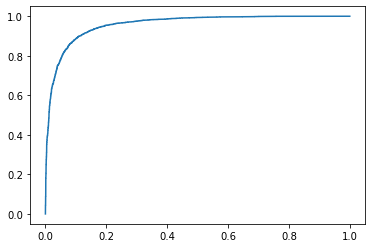

In [108]:
plt.plot(fpr, tpr)

In [122]:
my_answer = pd.DataFrame(clf_lr.predict(X_test_v1))

In [123]:
my_answer

,0
0,1
1,1
2,1
3,0
4,0
...,...
9995,1
9996,0
9997,0
9998,0


In [124]:
my_answer.columns = ['prediction']

In [125]:
my_answer['id'] = list(range(10000))

In [126]:
my_answer.to_csv('prediction_linclass.csv', index = False)